### 1: Import required packages & functions <a class="anchor" id="chapter1"></a>

In [1]:
# clear all variables
for i in list(globals().keys()):
    if(i[0] != '_'):
        exec('del {}'.format(i))

#suppress future warnings -- not really a good idea 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
        
# suppress future warnings -- not really a good idea 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')


# import required dependencies
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Dense
from numpy.random import seed
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, silhouette_score
import csv
import xlrd
import math
from matplotlib import figure
from IPython.display import FileLink, FileLinks
from IPython.display import set_matplotlib_formats

#import utils
#from utils import encode_features_v3

set_matplotlib_formats('png', 'pdf') # uses vector figures in pdf exports --
plt.style.use('seaborn-pastel')

# create a folder
def create_folder(folder):
    import os     
    try: 
        os.mkdir(folder) 
    except FileExistsError:
        print("Directory [ %s ] already exists"%folder)

## 2. Loading data obtained from Weka and Scale all Weights <a class="anchor" id="chapter3"></a>

#### Extracting features names and filter methods weights and Scaling all filter methods weights

In [2]:
from sklearn.preprocessing import MinMaxScaler

#create folder to store results
create_folder('Ranking')

# load all filter methods scores obtained from weka
weka_results = pd.read_excel('../data/weka_result_7_filter_methods.xlsx', header = 0) 

#Extracting all feature names
feature_names = weka_results[['Features']].copy()

#extracting all filters mathods values 
filters_wieghts = weka_results[['Chi-Squares', 'Gain Ratio', 'Information Gain', 'ReliefF', 'Symmetrical Uncertainty', 'Least Loss', 'Va']].copy()

#Scale all filter methods scores
scaler = MinMaxScaler()
scaled = scaler.fit_transform(filters_wieghts)

scaled_dataset = pd.DataFrame({'Chi2': scaled[:, 0], 'GainRatio': scaled[:, 1], 'InfoGain': scaled[:, 2], 'Relieff': scaled[:, 3], 'Symmetrical': scaled[:, 4], 'LeastLoss': scaled[:, 5], 'Va': scaled[:, 6]})
scaled_dataset.to_csv(r'Ranking/Scaled data.csv',index=False)


Directory [ Ranking ] already exists


## 3. Processing scaled data to get the average <a class="anchor" id="chapter4"></a>

In [3]:
#Find the sum of each filter method using all samples
scaled_columns_sum = pd.DataFrame()
scaled_columns_sum['Sum'] = np.around(scaled_dataset.sum(axis=0),2)
scaled_columns_sum = scaled_columns_sum.T #transpose

#Find the sum of each features score in each filter method
scaled_rows_sum = pd.DataFrame()
scaled_rows_sum['Sum'] = np.around(scaled_dataset.sum(axis=1),2)


# create DataFrame for each filter method
for df in ['chi2', 'gr', 'infog', 'rff', 'symmU', 'L2', 'va']:
    exec("%s_percentage = pd.DataFrame(feature_names.copy())"%df)

def cal_percentage(scaled_data, column_sum):
    data_percentage  = pd.DataFrame(scaled_data)
    for i in range(len(scaled_data)):
        data_percentage.iloc[i] = np.around((scaled_data.values[i]/column_sum.values)*100,0)
    
    return data_percentage

chi2_percentage = cal_percentage(scaled_dataset.Chi2, scaled_columns_sum.Chi2)
gr_percentage = cal_percentage(scaled_dataset.GainRatio, scaled_columns_sum.GainRatio)
infog_percentage = cal_percentage(scaled_dataset.InfoGain, scaled_columns_sum.InfoGain)
rff_percentage = cal_percentage(scaled_dataset.Relieff, scaled_columns_sum.Relieff)
symmU_percentage = cal_percentage(scaled_dataset.Symmetrical, scaled_columns_sum.Symmetrical)
L2_percentage = cal_percentage(scaled_dataset.LeastLoss, scaled_columns_sum.LeastLoss)
va_percentage = cal_percentage(scaled_dataset.Va, scaled_columns_sum.Va)


# chi2_percentage = chi2_percentage.sort_values(by='Features', ascending=False)
features_percentage = pd.DataFrame()
features_percentage = pd.DataFrame(feature_names)

# features_percentage = pd.DataFrame(chi2_percentage)
features_percentage['Chi2'] = chi2_percentage
features_percentage['InfoG'] = infog_percentage
features_percentage['GR'] = gr_percentage
features_percentage['Relieff'] = rff_percentage
features_percentage['SymmU'] = symmU_percentage
features_percentage['L2'] = L2_percentage
features_percentage['Va'] = va_percentage

#Find the sum of each features score in each filter method
features_percentage_rows_sum = pd.DataFrame()
features_percentage_rows_sum['Sum'] = np.around(features_percentage.iloc[:,1:8].sum(axis=1),0)
features_percentage['Sum'] = features_percentage_rows_sum
features_percentage.to_csv(r'Ranking/features_percentage.csv',mode = 'w',index=False)
features_percentage = features_percentage.sort_values(by='Sum', ascending=False)
features_percentage.reset_index(inplace=True, drop=True)
features_percentage.to_csv(r'Ranking/features_percentage_sorted.csv',mode = 'w',index=False)



#### ranking list with age and brain weight

Directory [ Figures ] already exists


<Figure size 864x576 with 0 Axes>

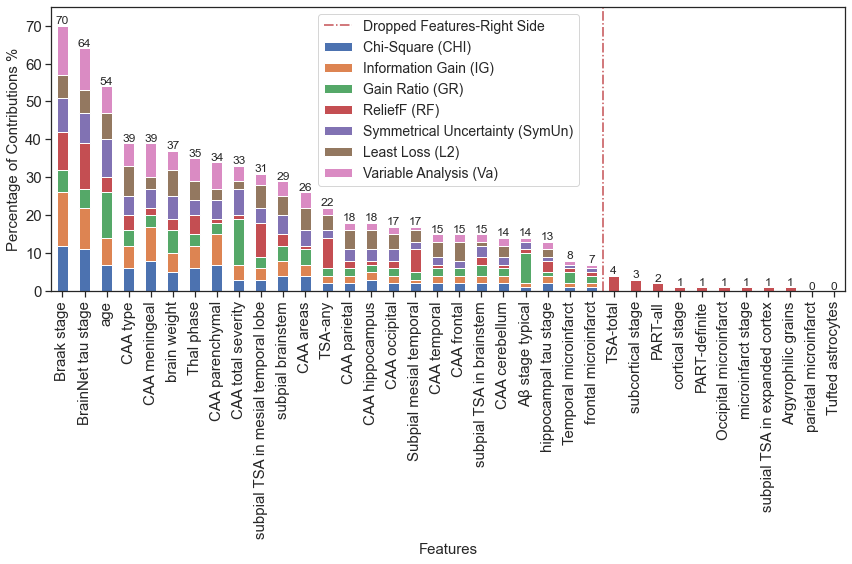

In [4]:
create_folder('Figures')

#Selected features above 6%
selected_features_with_AB = pd.DataFrame(features_percentage.iloc[0:25,0:1])
selected_features_with_AB.reset_index(inplace=True, drop=True)
selected_features_with_AB.to_csv(r'Ranking/selected_features_with_AB.csv',mode = 'w',index=False)


plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

from bokeh.palettes import GnBu9, OrRd9, Greys9, PuBu9, Spectral9, Viridis9, RdYlBu9, RdBu9, Plasma9, YlOrRd9
color = RdYlBu9
plt.rcParams['savefig.facecolor']='white'
sns.set_theme(style="ticks", color_codes=True)
# sns.set_theme(style="white", color_codes=True)

# %config InlineBackend.figure_format ='retina'
fig = plt.figure(figsize=(12,8))
# sns.set_style("whitegrid", {'axes.grid' : False})
ax = features_percentage.iloc[:,0:8].plot.bar(x = 'Features', stacked=True, figsize=(12,8))#, color=color)
features_sum = features_percentage.Sum
plt.ylim(0, 75)

#add percentages above bars
rects = ax.patches
for rect, label in zip(rects, features_sum):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()-0.25, label, "{}".format(int(label)), ha='center', va='bottom')

    
# fig, ax = plt.subplots()
# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Braak stage'; labels[1] = 'BrainNet tau stage'; labels[3] = 'CAA type'; labels[4] = 'CAA meningeal'; 
labels[6] = 'Thal phase'; labels[7] = 'CAA parenchymal'; labels[8] = 'CAA total severity'; labels[9] = 'subpial TSA in mesial temporal lobe';
labels[10] = 'subpial brainstem';labels[11] = 'CAA areas'; labels[12] = 'TSA-any'; labels[13] = 'CAA parietal'; 
labels[14] = 'CAA hippocampus';labels[15] = 'CAA occipital'; labels[16] = 'Subpial mesial temporal'; labels[17] = 'CAA temporal'; 
labels[19] = 'subpial TSA in brainstem'; labels[18] = 'CAA frontal';labels[20] = 'CAA cerebellum'; labels[21] = 'Aβ stage typical'; 
labels[22] = 'hippocampal tau stage';labels[23] = 'Temporal microinfarct'; labels[24] = 'frontal microinfarct'; 
labels[25] = 'TSA-total'; labels[26] = 'subcortical stage'; labels[27] = 'PART-all'; labels[28] = 'cortical stage'; 
labels[29] = 'PART-definite';labels[30] = 'Occipital microinfarct'; labels[31] = 'microinfarct stage'; labels[32] = 'subpial TSA in expanded cortex';
labels[33] = 'Argyrophilic grains'; labels[34] = 'parietal microinfarct'; labels[35] = 'Tufted astrocytes';
ax.set_xticklabels(labels)

#add line for dropping features and add it to the legend
plt.axvline(x=24.5, color='r', linestyle='-.', label='Dropped Features-Right Side')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
ax.legend(['Dropped Features-Right Side', 'Chi-Square (CHI)',
           'Information Gain (IG)', 'Gain Ratio (GR)', 'ReliefF (RF)',
           'Symmetrical Uncertainty (SymUn)', 'Least Loss (L2)', 'Variable Analysis (Va)'], fontsize=14);

plt.xlabel('Features', fontsize=15)
plt.ylabel('Percentage of Contributions %', fontsize=15)
plt.xticks(rotation=90)
plt.tick_params(labelsize=15)
plt.tight_layout()

plt.savefig('Figures/Ranking.png', dpi=300, bbox_inches='tight')
plt.savefig('Figures/Ranking.pdf', dpi=300, bbox_inches='tight')
